

<a href="https://colab.research.google.com/drive/1HHdRNI-Zz3oIKLd-itsutUwc1Lz1QaZX#scrollTo=Y3_sl9CiADjD" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  
<a href="https://github.com/WinetraubLab/roi-classification-foundation-model/tree/main" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# ResNet50 Model Overview

This notebook will compute the similarity heatmap between query patch and test image using ResNet50.

In [1]:
# @title Script Inputs

# # Input images - VH&E
# test_image_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Figure S4/FigureS4_c.jpg"
# query_patch_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Ref_images/6_i_resized.png"

# Input images - OCT
test_image_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Figure S4/FigureS4_a.jpg"
query_patch_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Ref_images/6_c_resized.png"

In [2]:
# @title Environment Setup

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# # remove and reclone the repo if already cloned the repo and want the updated code
# !rm -rf /content/roi-classification-foundation-model

# Clone repository
!git clone https://github.com/WinetraubLab/roi-classification-foundation-model.git
%cd ./roi-classification-foundation-model/

# Intall all requirements
!pip install -r requirements.txt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'roi-classification-foundation-model' already exists and is not an empty directory.
/content/roi-classification-foundation-model


In [3]:
# @title Compute Selected Patch Scores
# @title Compute Selected Patch Scores
# Imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import cv2
from PIL import Image
from resnet50_heatmap import get_patch_from_image
from resnet50_score import Resnet50Score
from tqdm import tqdm

# Boot up Resnet50Score
resnet_score = Resnet50Score()

test_image = Image.open(test_image_file_path).convert("RGB")

query_patch = Image.open(query_patch_file_path).convert("RGB")
query_emb = resnet_score.compute_patch_embedding(query_patch)

def compute_scores(points, points_type, color, plot_patch_over_image):
  scores = np.zeros((points.shape[0],1))
  with tqdm(total=len(scores)) as pbar:
    for i in range(0,len(scores)):
      patch = get_patch_from_image(test_image, points[i,0], points[i,1], plot_patch_over_image = plot_patch_over_image);
      patch_emb = resnet_score.compute_patch_embedding(patch)
      score = resnet_score.compute_similarity_between_embeddings(patch_emb, query_emb)
      scores[i] = score
      if plot_patch_over_image:
        print(f"{points_type} Score is {score:.3f}")
      else:
        pbar.update(1)
  return scores


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# grid points

grid_jump = 256
grid_y, grid_x = np.mgrid[128:(test_image.size[0]-128):grid_jump, 128:(test_image.size[1]-128):grid_jump]
grid_points = np.vstack((grid_x.flatten(),grid_y.flatten())).T

grid_scores = compute_scores(grid_points,'','',False)

100%|██████████| 49/49 [00:12<00:00,  4.06it/s]


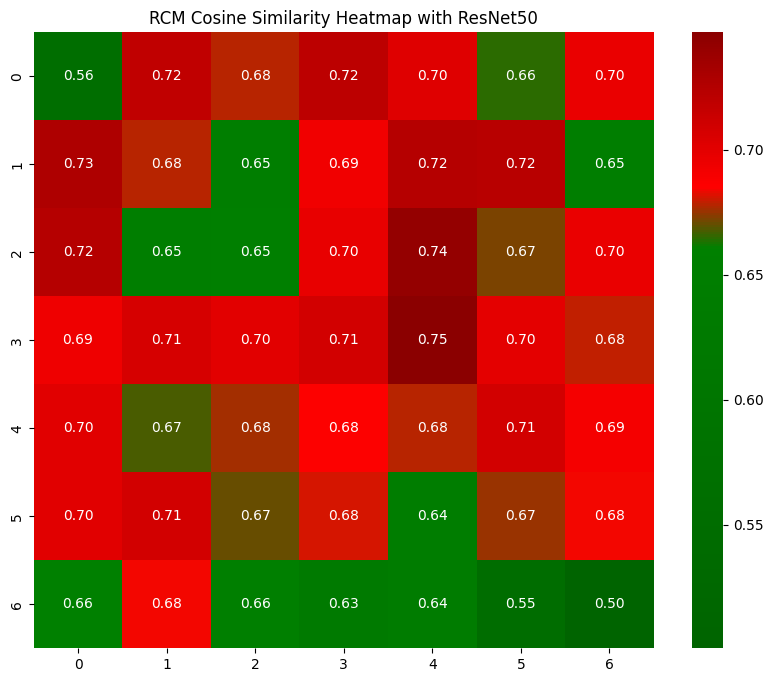

In [12]:
# @title heatmap

def heatmap(grid_scores, grid_x, grid_y, overlay_heatmap_path):
  '''
  Create a similarity heatmap based on the cosine similarity in each patch
  '''

  # Reshape `grid_scores` to match the grid structure
  num_rows, num_cols = grid_y.shape
  heatmap_data = grid_scores.reshape(num_rows, num_cols)

  colors = [(0.0, "darkgreen"), (0.65, "green"), (0.75, "red"), (1.0, "darkred")]
  cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

  # showing and saving similarity heatmap
  plt.figure(figsize=(10,8))
  sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".2f", cbar=True)
  plt.title('RCM Cosine Similarity Heatmap with ResNet50')
  plt.show()

  # for the purpose of overlaying heatmap onto the test image
  plt.figure(figsize=(10,8))
  sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt=".2f", cbar=False)
  plt.xticks([])  # Remove x-axis labels
  plt.yticks([])  # Remove y-axis labels
  plt.savefig(overlay_heatmap_path, format='png', dpi=300, bbox_inches='tight')
  plt.close()  # Close the plot to free up memory

overlay_heatmap_path = '/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/ResNet50/overlayed_heatmap.png'
heatmap(grid_scores, grid_x, grid_y, overlay_heatmap_path)


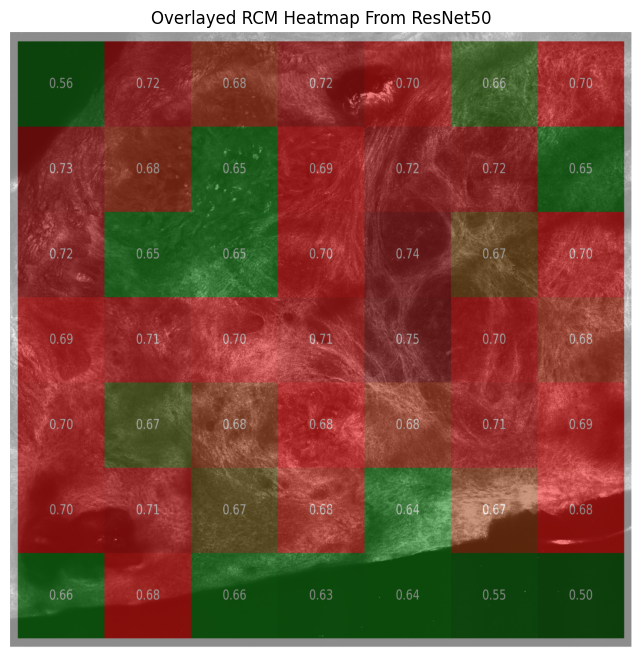

In [11]:
# @title Overlay

def overlay_heatmap_on_image(overlay_heatmap_path, original_image):
  '''
  Overlay the heatmap onto the original image
        '''
  original_image = cv2.imread(original_image)
  heatmap = cv2.imread(overlay_heatmap_path)

  # Resize the heatmap if necessary to match the original image size
  heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))

  overlay = original_image.copy()
  alpha = 0.5 # Adjust transparency level (0: fully transparent, 1: fully opaque)
  overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)

  plt.figure(figsize=(10, 8))
  plt.title('Overlayed RCM Heatmap From ResNet50')
  plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

overlay_heatmap_on_image(overlay_heatmap_path, test_image_file_path)